## Problem Statement

### Business Context
Tuko is a media analysis firm specializing in providing data-driven insights and strategic consultation services to news organizations, advertisers, and academic entities interested in media studies. Utilizing advanced data science techniques, the company aims to offer comprehensive analysis and recommendations based on global news trends and patterns.

### Objective
The firm has access to a rich dataset comprising news articles from various global sources, website traffic data, and domain locations. This dataset is a gold mine for understanding the dynamics of news dissemination, audience engagement, and content sentiment across different regions and media platforms.  By correlating news sentiment with traffic data, Tuko can assess the impact of news events on consumer behavior and adjust their campaigns accordingly. They have engaged you as a data scientist to carry out the following:
- Perform exploratory data analysis (EDA) to uncover patterns, insights, and anomalies in the data.
- Conduct topic modeling and sentiment analysis on the news content.
- Design and implement a PostgreSQL database schema to store ML features.
- Load and manage data within PostgreSQL, using it as a feature store for ML models.


### Data Description
`data.csv:`

- article_id: Unique article id
- source_id
- source_name: Source name
- author: The author of the article
- title: The headline or title of the article.
- description: A description or snippet from the article. 
- url: The direct URL to the article. 
- url_to_image: The URL to a relevant image for the article.
- published_at: The date and time that the article was published, in UTC
- content: The unformatted content of the article, where available. This is truncated to 200 chars
- category: Search query used to fetch data
- article: Full content of that article
- title_sentiment: Sentiment of the title


`domains_location.csv:`

- SourceCommonName: Common  Domain Name (bbc.co.uk, cnn.com)
- location: Country short code (US, UK, CA)
- Country: Country name

`traffic_data.csv:`

- GlobalRank: Rank of the domain globally
- TldRank: Rank of the TLD (Top-Level Domain [.com, .org…..etc]) among other similar TLD (Top-Level Domain [.com, .org…..etc])
- Domain: 
TLD: TLD (Top-Level Domain [.com, .org…..etc])
RefSubNets: The number of Referring Subnets found for this domain in the Fresh Index.
RefIPs: The number of Referring IPs found for this domain in the Fresh Index.
IDN_Domain: Internationalized Domain Name
IDN_TLD: Internationalized Domain Name Top-Level Domain.
PrevGlobalRank: Previous Global Rank.
PrevTldRank: Previous TLD Rank.
PrevRefSubNets: Previous number of referring subnets.
PrevRefIPs: Previous number of referring IPs.

## Importing necessary libraries

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the dataset

In [3]:
trafficdf = pd.read_csv('traffic.csv')
ratingdf = pd.read_csv('rating.csv')
domaindf = pd.read_csv('domains_location.csv')

## Data Overview

In [4]:
# first five rows of our rating dataset
ratingdf.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,article,title_sentiment
0,81664,NaN,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral
1,81667,NaN,CNA,NaN,nice claim top spot in ligue 1 with late win a...,Nice moved into provisional first place in the...,https://www.channelnewsasia.com/sport/nice-cla...,https://onecms-res.cloudinary.com/image/upload...,2023-10-27 21:28:48.000000,Nice moved into provisional first place in the...,Monaco,nice moved into provisional first place in the...,Positive
2,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative
3,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral
4,81703,NaN,Digital Trends,Jason Struss,everything leaving max (formerly hbo max) in n...,From Gangs of London to Fear the Walking Dead ...,https://www.digitaltrends.com/movies/everythin...,https://www.digitaltrends.com/wp-content/uploa...,2023-10-23 23:09:18.000000,"Everything ends. No, I’m not having an existen...",Madagascar,"everything ends. no, i’m not having an existen...",Neutral


In [5]:
# first five rows of our domain location dataset
domaindf.head()

,SourceCommonName,location,Country
0,00221.info,SG,Senegal
1,01net.com,FR,France
2,01net.it,IT,Italy
3,0223.com.ar,AR,Argentina
4,022china.com,CH,China


In [6]:
# first five rows of our traffic dataset
trafficdf.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940
3,4,4,twitter.com,com,404985,1757127,twitter.com,com,4,4,404998,1753939
4,5,5,instagram.com,com,364746,1598085,instagram.com,com,5,5,364618,1594892


In [7]:
# shape of our data
print('There are', ratingdf.shape[0], 'rows and', ratingdf.shape[1], 'columns in our ratingdf', '\n')


print('There are', domaindf.shape[0], 'rows and', domaindf.shape[1], 'columns in our domaindf', '\n')

print('There are', trafficdf.shape[0], 'rows and', trafficdf.shape[1], 'columns in our trafficdf')

There are 58356 rows and 13 columns in our ratingdf 

There are 37802 rows and 3 columns in our domaindf 

There are 1000000 rows and 12 columns in our trafficdf


In [8]:
print(ratingdf.columns, '\n')
print(domaindf.columns, '\n')
print(trafficdf.columns, '\n')


Index(['article_id', 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'url_to_image', 'published_at', 'content',
       'category', 'article', 'title_sentiment'],
      dtype='object') 

Index(['SourceCommonName', 'location', 'Country'], dtype='object') 

Index(['GlobalRank', 'TldRank', 'Domain', 'TLD', 'RefSubNets', 'RefIPs',
       'IDN_Domain', 'IDN_TLD', 'PrevGlobalRank', 'PrevTldRank',
       'PrevRefSubNets', 'PrevRefIPs'],
      dtype='object') 



In [9]:
# checking data types of our columns
ratingdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58356 entries, 0 to 58355
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       58356 non-null  int64 
 1   source_id        17771 non-null  object
 2   source_name      58356 non-null  object
 3   author           56193 non-null  object
 4   title            58356 non-null  object
 5   description      58346 non-null  object
 6   url              58356 non-null  object
 7   url_to_image     54905 non-null  object
 8   published_at     58356 non-null  object
 9   content          58356 non-null  object
 10  category         58335 non-null  object
 11  article          58356 non-null  object
 12  title_sentiment  58356 non-null  object
dtypes: int64(1), object(12)
memory usage: 5.8+ MB


-

In [10]:
domaindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37802 entries, 0 to 37801
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SourceCommonName  37802 non-null  object
 1   location          37802 non-null  object
 2   Country           37801 non-null  object
dtypes: object(3)
memory usage: 886.1+ KB


-

In [11]:
trafficdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   GlobalRank      1000000 non-null  int64 
 1   TldRank         1000000 non-null  int64 
 2   Domain          1000000 non-null  object
 3   TLD             1000000 non-null  object
 4   RefSubNets      1000000 non-null  int64 
 5   RefIPs          1000000 non-null  int64 
 6   IDN_Domain      1000000 non-null  object
 7   IDN_TLD         1000000 non-null  object
 8   PrevGlobalRank  1000000 non-null  int64 
 9   PrevTldRank     1000000 non-null  int64 
 10  PrevRefSubNets  1000000 non-null  int64 
 11  PrevRefIPs      1000000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 91.6+ MB


- 

## Exploratory Data Analysis (EDA)

In [12]:
# creating function for histogram n boxplot
def histogram_boxplot(fonedf, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=fonedf, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=fonedf, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=fonedf, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        fonedf[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        fonedf[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    
    

# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

www.etfdailynews.com            16746
www.globenewswire.com            5423
economictimes.indiatimes.com     5310
www.globalsecurity.org           3119
www.forbes.com                   2784
timesofindia.indiatimes.com      2194
abcnews.go.com                   2058
www.businessinsider.com          2034
www.bbc.co.uk                    2032
punchng.com                      1800
Name: domain, dtype: int64


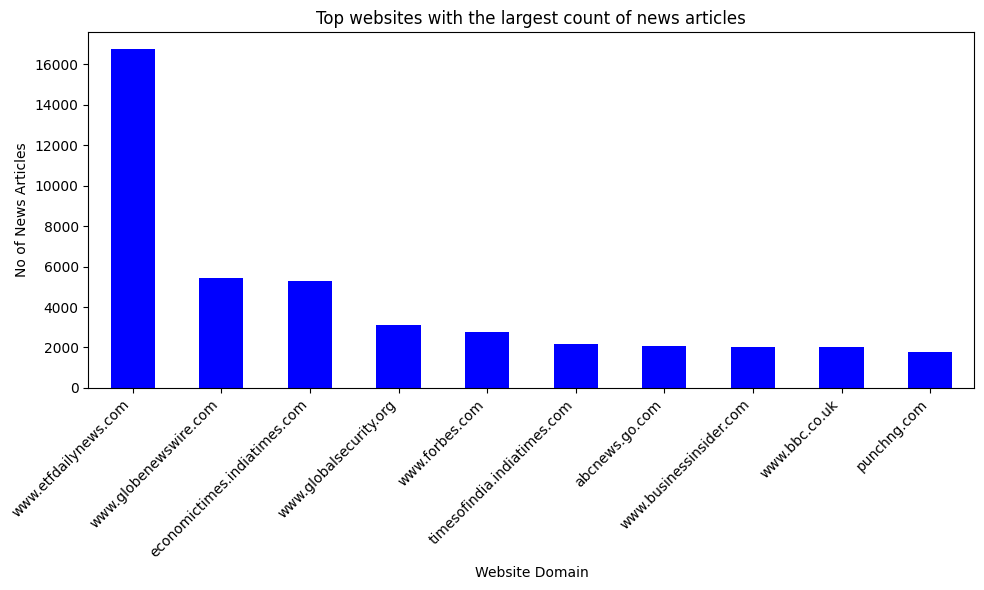

In [16]:
import sys, os
if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))


from src.utils import find_top_websites
from src.loader import NewsDataLoader

loader = NewsDataLoader()
news_data = loader.load_data('C:/Users/Jojo/Desktop/10A/10x/Week0-Cb/rating.csv')

top_websites = find_top_websites(news_data)
print(top_websites)

#ploting the date ;;; hope this works
plt.figure(figsize=(10,6))
top_websites.plot(kind='bar',color='blue')
plt.title('Top websites with the largest count of news articles')
plt.xlabel('Website Domain')
plt.ylabel('No of News Articles')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

In [17]:
sns.countplot(data=ratingdf, x='url');

Error in callback <function _draw_all_if_interactive at 0x0000018707F4D080> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Questions

In [13]:
# Who are the top and bottom 10 
# Websites that have the largest count of news articles
ratingdf['url'].value_counts()

https://www.ibtimes.com/uk-bans-recreational-use-nitrous-oxide-3717885                                                                             2
https://www.businessinsider.com/moving-to-mexico-from-us-merida-safety-cost-healthcare-2023-11                                                     2
https://readwrite.com/unlock-adtech-with-7-best-ai-tools-in-2023-and-beyond/                                                                       2
https://www.forbes.com/sites/forbestechcouncil/2023/11/08/seizing-opportunities-why-companies-should-invest-in-technology-resiliency/              2
https://readwrite.com/ibm-bets-500m-on-business-focused-ai-startups/                                                                               2
                                                                                                                                                  ..
https://www.etfdailynews.com/2023/11/05/enn-energy-otcmktsxngsy-shares-pass-below-fifty-day-moving-average

In [14]:
sns.countplot(data=ratingdf, x='url')

<Axes: xlabel='url', ylabel='count'>

Error in callback <function _draw_all_if_interactive at 0x0000012D7743C220> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

## Data Preprocessing

- Missing value treatment
- Feature engineering (if needed)
- Outlier detection and treatment (if needed)
- Preparing data for modeling
- Any other preprocessing steps (if needed)